插入套件和QuantLib，輸入變數

In [10]:
sigma = float(input('sigma?'))
a = float(input('a?'))
timestep = int(input('timestep?'))
length = float(input('length?'))
forward_rate = float(input('forward rate(%)?'))*0.01
num_paths = int(input('要模擬幾次?'))
current_Stock_Price=float(input('目前股價?'))
tu=float(input('dt?'))
strike_price=float(input('履約價?'))
risk_free_interest=float(input('無風險利率(%)?'))*0.01

np.random.seed(1)
day_count = ql.Thirty360()
todays_date = ql.Date(13, 5, 2020)

sigma?0.05
a?0.1
timestep?1200
length?1
forward rate(%)?3
要模擬幾次?300
目前股價?100
dt?0.01
履約價?105
無風險利率(%)?1


使用QuantLib套件，計算Hull White Term Structure 模擬出來的Short rate，並畫出圖

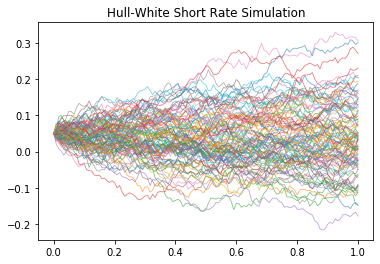

In [6]:
ql.Settings.instance().evaluationDate = todays_date
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr
  
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
  plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

將Short rate 套入GBM 中，模擬出股價

股票價格波動圖


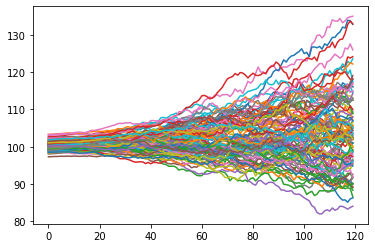

In [7]:
def  genBrownPath(T, mu, sigma, S0, dt):
    
    W = [0] + np.random.standard_normal(size = 1)    
    W = (W + np.random.standard_normal(size = 1))*dt**0.5
    Z=[]
    for i in range(timestep):
        Z.append(S0*np.exp((float(mu[i])-0.5*sigma**2)*float(time[i])+sigma*W))     
    plt.plot(Z)
    return np.array(Z)
print("股票價格波動圖")   
ZZ=[]
for i in range(0,num_paths):
    ZZ.append(genBrownPath(timestep, paths[i, :], sigma, current_Stock_Price, tu))

將各種模擬結果的最後一期蒐集起來

In [8]:
SSS=[]
for i in range(0,num_paths):
    SS=float(ZZ[i][-1])
    SSS.append(SS)

計算call price 和 put price，折現至第一期

In [9]:
call = []
for i in range(0,num_paths):
    if SSS[i]>=strike_price:
        call.append(SSS[i]-strike_price)
    else:
      call.append(float(0))
call_s=sum(call[0:num_paths+1])/num_paths           
callprice=call_s*np.exp(-timestep*risk_free_interest)
print("Call price=")
print(callprice)

put=[]
for i in range(0,num_paths):
    if SSS[i]<strike_price:
        put.append(strike_price-SSS[i])
    else:
      put.append(float(0)) 
put_s=sum(put[0:num_paths+1])/num_paths
putprice=put_s*np.exp(-timestep*risk_free_interest)
print("Put price=")
print(putprice)



Call price=
1.1735910300189005
Put price=
1.3848342814998271
